# Day 5: Backtesting Portfolio Strategies
## Week 5: Portfolio Optimization

---

**Learning Objectives:**
- Implement rolling portfolio backtests
- Compare optimization strategies over time
- Calculate realistic performance metrics
- Account for transaction costs and rebalancing

In [1]:
# Day 5 Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

TRADING_DAYS = 252
RF_RATE = 0.05

# Load data
df = pd.read_csv('../datasets/raw_data/combined_adjusted_close.csv', 
                 index_col='Date', parse_dates=True)

assets = ['AAPL', 'MSFT', 'JPM', 'XOM', 'GLD', 'TLT']
prices = df[assets].dropna()
returns = prices.pct_change().dropna()

print("=" * 60)
print("BACKTESTING PORTFOLIO STRATEGIES - DAY 5")
print("=" * 60)
print(f"Period: {returns.index[0].date()} to {returns.index[-1].date()}")
print(f"Assets: {assets}")

BACKTESTING PORTFOLIO STRATEGIES - DAY 5
Period: 2019-01-03 to 2026-01-16
Assets: ['AAPL', 'MSFT', 'JPM', 'XOM', 'GLD', 'TLT']


## 1. Portfolio Strategy Classes

In [2]:
# Define portfolio strategies
print("=" * 60)
print("PORTFOLIO STRATEGY DEFINITIONS")
print("=" * 60)

class PortfolioStrategy:
    """Base class for portfolio strategies."""
    
    def __init__(self, name):
        self.name = name
    
    def get_weights(self, returns_window):
        """Return portfolio weights based on historical data."""
        raise NotImplementedError


class EqualWeight(PortfolioStrategy):
    """Equal weight (1/N) portfolio."""
    
    def __init__(self):
        super().__init__('Equal Weight')
    
    def get_weights(self, returns_window):
        n = returns_window.shape[1]
        return np.array([1/n] * n)


class MinVariance(PortfolioStrategy):
    """Minimum variance portfolio."""
    
    def __init__(self):
        super().__init__('Min Variance')
    
    def get_weights(self, returns_window):
        cov = returns_window.cov().values * TRADING_DAYS
        n = len(cov)
        
        def portfolio_vol(w):
            return np.sqrt(np.dot(w.T, np.dot(cov, w)))
        
        constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        bounds = tuple((0, 1) for _ in range(n))
        
        result = minimize(portfolio_vol, np.array([1/n]*n), method='SLSQP',
                         bounds=bounds, constraints=constraints)
        return result.x


class MaxSharpe(PortfolioStrategy):
    """Maximum Sharpe ratio portfolio."""
    
    def __init__(self, rf_rate=RF_RATE):
        super().__init__('Max Sharpe')
        self.rf_rate = rf_rate
    
    def get_weights(self, returns_window):
        mean_ret = returns_window.mean().values * TRADING_DAYS
        cov = returns_window.cov().values * TRADING_DAYS
        n = len(mean_ret)
        
        def neg_sharpe(w):
            ret = np.dot(w, mean_ret)
            vol = np.sqrt(np.dot(w.T, np.dot(cov, w)))
            return -(ret - self.rf_rate) / vol
        
        constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        bounds = tuple((0, 0.4) for _ in range(n))  # Max 40% per asset
        
        result = minimize(neg_sharpe, np.array([1/n]*n), method='SLSQP',
                         bounds=bounds, constraints=constraints)
        return result.x


class RiskParity(PortfolioStrategy):
    """Risk parity portfolio."""
    
    def __init__(self):
        super().__init__('Risk Parity')
    
    def get_weights(self, returns_window):
        cov = returns_window.cov().values * TRADING_DAYS
        n = len(cov)
        
        def risk_contribution(w):
            port_vol = np.sqrt(np.dot(w.T, np.dot(cov, w)))
            mrc = np.dot(cov, w) / port_vol
            rc = w * mrc
            target = port_vol / n
            return np.sum((rc - target) ** 2)
        
        constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        bounds = tuple((0.01, 1) for _ in range(n))
        
        result = minimize(risk_contribution, np.array([1/n]*n), method='SLSQP',
                         bounds=bounds, constraints=constraints)
        return result.x


class InverseVolatility(PortfolioStrategy):
    """Inverse volatility weighted portfolio."""
    
    def __init__(self):
        super().__init__('Inverse Vol')
    
    def get_weights(self, returns_window):
        vol = returns_window.std().values * np.sqrt(TRADING_DAYS)
        inv_vol = 1 / vol
        return inv_vol / inv_vol.sum()


print("Strategies defined:")
strategies = [
    EqualWeight(),
    MinVariance(),
    MaxSharpe(),
    RiskParity(),
    InverseVolatility()
]
for s in strategies:
    print(f"  - {s.name}")

PORTFOLIO STRATEGY DEFINITIONS
Strategies defined:
  - Equal Weight
  - Min Variance
  - Max Sharpe
  - Risk Parity
  - Inverse Vol


## 2. Backtest Engine

In [3]:
# Backtest engine
print("=" * 60)
print("BACKTEST ENGINE")
print("=" * 60)

def backtest_portfolio(strategy, returns, lookback=252, rebalance_freq=21, 
                       transaction_cost=0.001):
    """
    Run backtest for a portfolio strategy.
    
    Parameters:
    - strategy: PortfolioStrategy instance
    - returns: DataFrame of asset returns
    - lookback: Days of history for optimization
    - rebalance_freq: Days between rebalancing
    - transaction_cost: One-way transaction cost
    
    Returns:
    - DataFrame with portfolio returns and weights
    """
    n_assets = returns.shape[1]
    dates = returns.index[lookback:]
    
    portfolio_returns = []
    weights_history = []
    turnover_history = []
    
    current_weights = np.array([1/n_assets] * n_assets)
    
    for i, date in enumerate(dates):
        # Get window of historical returns
        window_end = returns.index.get_loc(date)
        window_start = window_end - lookback
        returns_window = returns.iloc[window_start:window_end]
        
        # Rebalance if needed
        if i % rebalance_freq == 0:
            try:
                new_weights = strategy.get_weights(returns_window)
            except:
                new_weights = current_weights  # Keep current if optimization fails
            
            # Calculate turnover
            turnover = np.sum(np.abs(new_weights - current_weights))
            current_weights = new_weights
        else:
            turnover = 0
        
        # Calculate return for this period
        period_return = returns.loc[date].values
        portfolio_ret = np.dot(current_weights, period_return)
        
        # Subtract transaction costs (on turnover days)
        if turnover > 0:
            portfolio_ret -= transaction_cost * turnover
        
        # Update weights for drift
        current_weights = current_weights * (1 + period_return)
        current_weights = current_weights / current_weights.sum()
        
        portfolio_returns.append(portfolio_ret)
        weights_history.append(current_weights.copy())
        turnover_history.append(turnover)
    
    result = pd.DataFrame({
        'date': dates,
        'return': portfolio_returns,
        'turnover': turnover_history
    }).set_index('date')
    
    return result

print("Backtest function defined.")

BACKTEST ENGINE
Backtest function defined.


In [4]:
# Run backtests
print("=" * 60)
print("RUNNING BACKTESTS")
print("=" * 60)

results = {}
for strategy in strategies:
    print(f"  Running {strategy.name}...")
    results[strategy.name] = backtest_portfolio(
        strategy, returns, 
        lookback=252, 
        rebalance_freq=21,  # Monthly
        transaction_cost=0.001
    )

print("\n✅ Backtests complete!")

RUNNING BACKTESTS
  Running Equal Weight...
  Running Min Variance...
  Running Max Sharpe...
  Running Risk Parity...
  Running Inverse Vol...

✅ Backtests complete!


## 3. Performance Metrics

In [5]:
# Calculate performance metrics
print("=" * 60)
print("PERFORMANCE METRICS")
print("=" * 60)

def calculate_metrics(returns_series):
    """Calculate comprehensive performance metrics."""
    # Annualized metrics
    total_return = (1 + returns_series).prod() - 1
    n_years = len(returns_series) / TRADING_DAYS
    ann_return = (1 + total_return) ** (1 / n_years) - 1
    ann_vol = returns_series.std() * np.sqrt(TRADING_DAYS)
    
    # Sharpe ratio
    sharpe = (ann_return - RF_RATE) / ann_vol if ann_vol > 0 else 0
    
    # Maximum drawdown
    cumulative = (1 + returns_series).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Calmar ratio
    calmar = ann_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Sortino ratio
    downside_returns = returns_series[returns_series < 0]
    downside_vol = downside_returns.std() * np.sqrt(TRADING_DAYS)
    sortino = (ann_return - RF_RATE) / downside_vol if downside_vol > 0 else 0
    
    # Win rate
    win_rate = (returns_series > 0).mean()
    
    return {
        'Total Return': total_return,
        'Ann. Return': ann_return,
        'Ann. Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Max Drawdown': max_drawdown,
        'Calmar Ratio': calmar,
        'Win Rate': win_rate
    }

# Calculate metrics for all strategies
metrics_list = []
for name, result in results.items():
    metrics = calculate_metrics(result['return'])
    metrics['Strategy'] = name
    metrics['Avg Turnover'] = result['turnover'].mean()
    metrics_list.append(metrics)

metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df[['Strategy', 'Total Return', 'Ann. Return', 'Ann. Volatility', 
                         'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown', 'Calmar Ratio', 
                         'Win Rate', 'Avg Turnover']]

print("\n📊 Performance Summary:")
print(metrics_df.round(4).to_string(index=False))

PERFORMANCE METRICS

📊 Performance Summary:
    Strategy  Total Return  Ann. Return  Ann. Volatility  Sharpe Ratio  Sortino Ratio  Max Drawdown  Calmar Ratio  Win Rate  Avg Turnover
Equal Weight        1.6191       0.1733           0.1575        0.7828         0.9974       -0.2426        0.7145    0.5553        0.0022
Min Variance        0.5782       0.0787           0.1103        0.2600         0.3519       -0.2447        0.3216    0.5428        0.0050
  Max Sharpe        1.6604       0.1764           0.1609        0.7855         1.0465       -0.1610        1.0953    0.5685        0.0135
 Risk Parity        0.9622       0.1184           0.1165        0.5872         0.7800       -0.1849        0.6403    0.5534        0.0029
 Inverse Vol        1.2201       0.1416           0.1305        0.7014         0.9024       -0.2079        0.6810    0.5553        0.0025


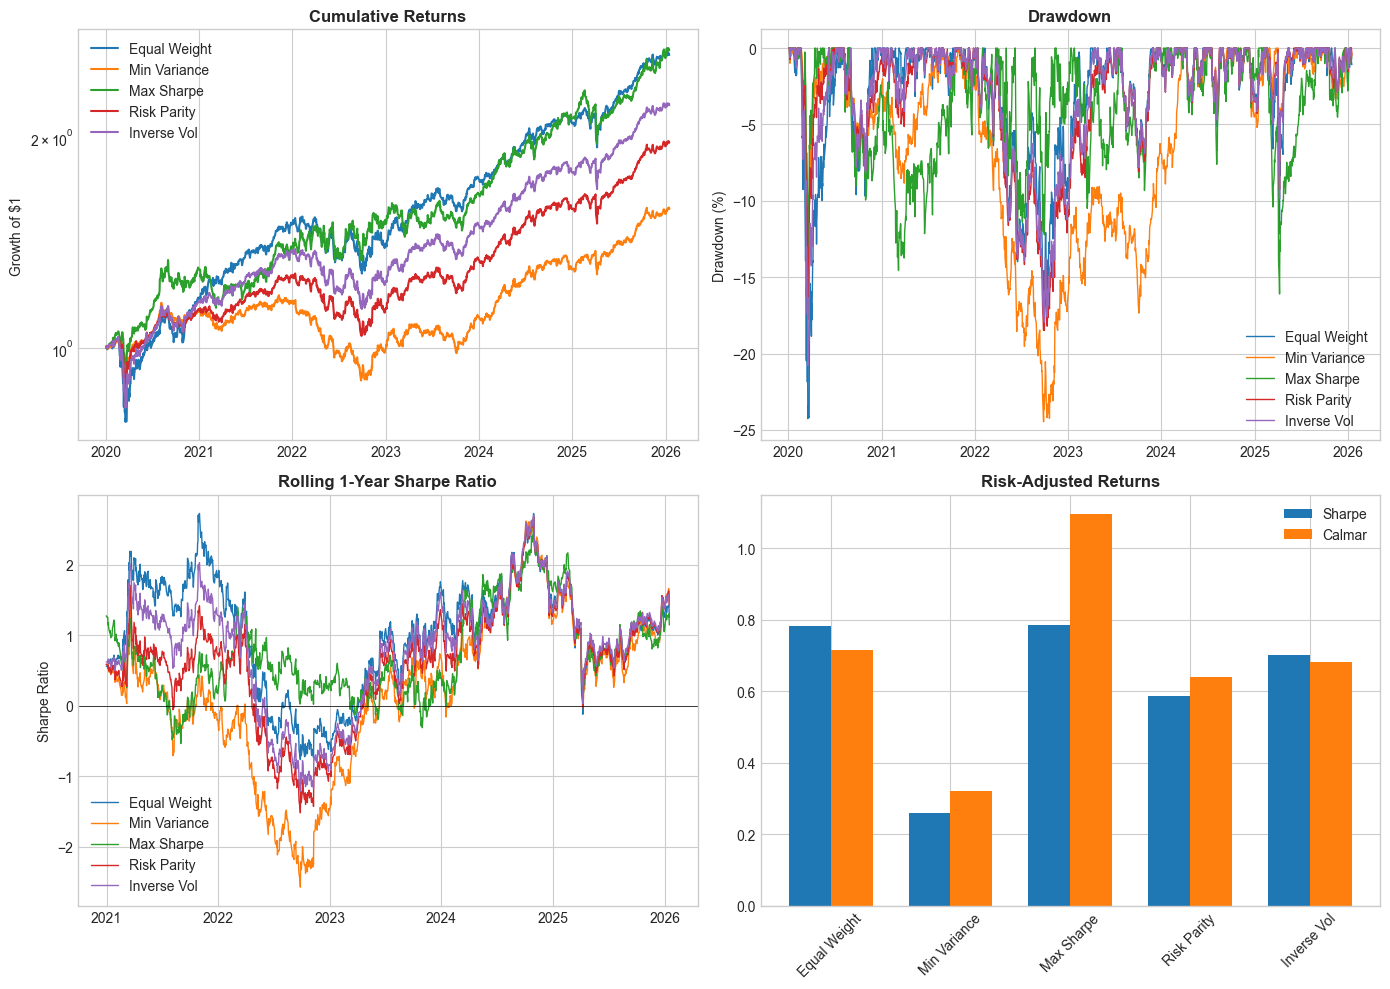

In [6]:
# Visualize cumulative returns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cumulative returns
for name, result in results.items():
    cumret = (1 + result['return']).cumprod()
    axes[0, 0].plot(cumret.index, cumret.values, label=name, linewidth=1.5)

axes[0, 0].set_title('Cumulative Returns', fontweight='bold')
axes[0, 0].set_ylabel('Growth of $1')
axes[0, 0].legend()
axes[0, 0].set_yscale('log')

# Drawdown
for name, result in results.items():
    cumret = (1 + result['return']).cumprod()
    running_max = cumret.cummax()
    drawdown = (cumret - running_max) / running_max
    axes[0, 1].plot(drawdown.index, drawdown.values * 100, label=name, linewidth=1)

axes[0, 1].set_title('Drawdown', fontweight='bold')
axes[0, 1].set_ylabel('Drawdown (%)')
axes[0, 1].legend()

# Rolling Sharpe
window = 252
for name, result in results.items():
    rolling_ret = result['return'].rolling(window).mean() * TRADING_DAYS
    rolling_vol = result['return'].rolling(window).std() * np.sqrt(TRADING_DAYS)
    rolling_sharpe = (rolling_ret - RF_RATE) / rolling_vol
    axes[1, 0].plot(rolling_sharpe.index, rolling_sharpe.values, label=name, linewidth=1)

axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 0].set_title('Rolling 1-Year Sharpe Ratio', fontweight='bold')
axes[1, 0].set_ylabel('Sharpe Ratio')
axes[1, 0].legend()

# Performance bar chart
x = np.arange(len(metrics_df))
width = 0.35

axes[1, 1].bar(x - width/2, metrics_df['Sharpe Ratio'], width, label='Sharpe')
axes[1, 1].bar(x + width/2, metrics_df['Calmar Ratio'], width, label='Calmar')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics_df['Strategy'], rotation=45)
axes[1, 1].set_title('Risk-Adjusted Returns', fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 4. Transaction Cost Sensitivity

TRANSACTION COST SENSITIVITY


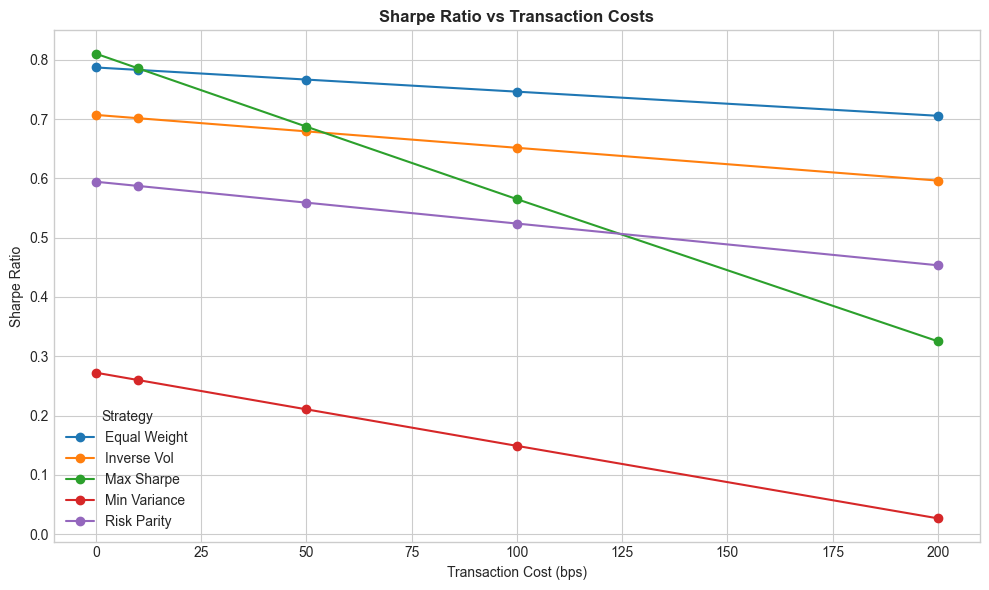


📊 Sharpe Ratio Sensitivity:
Strategy  Equal Weight  Inverse Vol  Max Sharpe  Min Variance  Risk Parity
TC (bps)                                                                  
0.0              0.787        0.707       0.810         0.272        0.594
10.0             0.783        0.701       0.786         0.260        0.587
50.0             0.767        0.679       0.687         0.211        0.559
100.0            0.746        0.651       0.565         0.149        0.524
200.0            0.705        0.596       0.325         0.027        0.453


In [7]:
# Transaction cost sensitivity
print("=" * 60)
print("TRANSACTION COST SENSITIVITY")
print("=" * 60)

tc_levels = [0, 0.001, 0.005, 0.01, 0.02]

tc_sensitivity = []
for tc in tc_levels:
    for strategy in strategies:
        result = backtest_portfolio(
            strategy, returns, 
            lookback=252, 
            rebalance_freq=21,
            transaction_cost=tc
        )
        metrics = calculate_metrics(result['return'])
        tc_sensitivity.append({
            'Strategy': strategy.name,
            'TC (bps)': tc * 10000,
            'Ann. Return': metrics['Ann. Return'],
            'Sharpe': metrics['Sharpe Ratio']
        })

tc_df = pd.DataFrame(tc_sensitivity)

# Pivot for visualization
sharpe_pivot = tc_df.pivot(index='TC (bps)', columns='Strategy', values='Sharpe')

fig, ax = plt.subplots(figsize=(10, 6))
sharpe_pivot.plot(ax=ax, marker='o')
ax.set_xlabel('Transaction Cost (bps)')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio vs Transaction Costs', fontweight='bold')
ax.legend(title='Strategy')

plt.tight_layout()
plt.show()

print("\n📊 Sharpe Ratio Sensitivity:")
print(sharpe_pivot.round(3))

## 📝 Key Takeaways - Day 5

### Backtesting Best Practices:
1. **Rolling windows**: Re-estimate parameters periodically
2. **Transaction costs**: Include realistic trading costs
3. **Rebalancing frequency**: Trade-off between accuracy and costs
4. **Multiple metrics**: Don't rely on just Sharpe ratio

### Strategy Observations:
| Strategy | Characteristics |
|----------|----------------|
| Equal Weight | Simple, robust, low turnover |
| Min Variance | Low volatility, may miss rallies |
| Max Sharpe | Highest Sharpe, but estimation error |
| Risk Parity | Balanced risk, often high bond allocation |
| Inverse Vol | Simple risk-based, similar to risk parity |

### Interview Questions:
- "How do you backtest a portfolio strategy?"
- "What's the impact of transaction costs on strategy performance?"
- "Why might a simple equal-weight portfolio outperform?"